# Run `feature_extraction.py`, `train_test_split.ipynb`, and `tfidf.ipynb` first!
(in respective order)

## Imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

from collections import Counter
from helpers import resample_data, get_submission_ready, svd_reduce_and_combine

## Load in files

In [254]:
X_train_full = pd.read_csv("data/components/tfidf/X_train_full.csv")
y_train_full = pd.read_csv("data/components/y_train.csv")
X_test_full = pd.read_csv("data/components/tfidf/X_test_full.csv")
y_test = pd.read_csv("data/components/y_test.csv")
submission = pd.read_csv("data/components/tfidf/submission_full.csv")

## Feature transformation

In [157]:
X_train_full_new_features = X_train_full.copy()

In [164]:
print(X_train_full.columns.tolist())

['ability', 'able', 'absolutely', 'across', 'act', 'acted', 'acting', 'action', 'actor', 'actors', 'actress', 'actual', 'adaptation', 'add', 'added', 'addition', 'adds', 'admit', 'adult', 'adults', 'adventure', 'age', 'ages', 'ago', 'agree', 'ahead', 'air', 'alien', 'alive', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'amazing', 'amazon', 'america', 'american', 'among', 'amount', 'an', 'and', 'animated', 'animation', 'anime', 'annoying', 'another', 'anymore', 'anyone', 'anything', 'anyway', 'apart', 'apparently', 'appear', 'appearance', 'appears', 'appreciate', 'art', 'as', 'aside', 'ask', 'aspect', 'at', 'atmosphere', 'attack', 'attempt', 'attempts', 'attention', 'audience', 'audiences', 'audio', 'available', 'average', 'award', 'away', 'awesome', 'awful', 'baby', 'back', 'background', 'bad', 'band', 'based', 'basic', 'basically', 'battle', 'be', 'beat', 'beautiful', 'beautifully', 'beauty', 'became', 'become', 'becomes', 'becoming', 'begin', 'beginning

In [216]:
five_star_words = [
    'amazing', 'fantastic', 'wonderful', 'excellent', 'perfect', 
    'great', 'awesome', 'brilliant', 'best', 'incredible', 'masterpiece', 'superb', 'loved'
]

four_star_words = [
    'good', 'enjoyable', 'like', 'satisfied', 'pretty good', 
    'impressive', 'recommended', 'solid', 'well', 'memorable'
]

three_star_words = [
    'average', 'decent', 'okay', 'fine', 'fair', 'standard', 
    'nothing special', 'expected', 'mediocre', 'ok', 'okay'
]

two_star_words = [
    'disappointed', 'boring', 'slow', 'dull', 'forgettable', 
    'underwhelming', 'poor', 'weak', 'unimpressive', 
    'predictable', 'annoying', 'cheap', 'forced', 'problem',
    'basic'
]

one_star_words = [
    'worst', 'terrible', 'horrible', 'awful', 'waste', 'disgusting', 
    'disaster', 'hate', 'unwatchable', 'bad', 'trash'
]

In [217]:
five_star_col = [col for col in X_train_full_new_features.columns if col in five_star_words]
four_star_col = [col for col in X_train_full_new_features.columns if col in four_star_words]
three_star_col = [col for col in X_train_full_new_features.columns if col in three_star_words]
two_star_col = [col for col in X_train_full_new_features.columns if col in two_star_words]
one_star_col = [col for col in X_train_full_new_features.columns if col in one_star_words]

In [220]:
X_train_full_new_features['five_star_words'] = X_train_full[five_star_col].sum(axis=1)
X_train_full_new_features=X_train_full_new_features.drop(columns=five_star_col, axis=1)

X_train_full_new_features['four_star_words'] = X_train_full[four_star_col].sum(axis=1)
X_train_full_new_features=X_train_full_new_features.drop(columns=four_star_col, axis=1)

X_train_full_new_features['three_star_words'] = X_train_full[three_star_col].sum(axis=1)
X_train_full_new_features=X_train_full_new_features.drop(columns=three_star_col, axis=1)

X_train_full_new_features['two_star_words'] = X_train_full[two_star_col].sum(axis=1)
X_train_full_new_features=X_train_full_new_features.drop(columns=two_star_col, axis=1)

X_train_full_new_features['one_star_words'] = X_train_full[one_star_col].sum(axis=1)
X_train_full_new_features=X_train_full_new_features.drop(columns=one_star_col, axis=1)

In [230]:
X_test_full_new_features = X_test_full.copy()

In [228]:
submission_new_features = submission.copy()

In [231]:
X_test_full_new_features['five_star_words'] = X_test_full[five_star_col].sum(axis=1)
X_test_full_new_features=X_test_full_new_features.drop(columns=five_star_col, axis=1)

X_test_full_new_features['four_star_words'] = X_test_full[four_star_col].sum(axis=1)
X_test_full_new_features=X_test_full_new_features.drop(columns=four_star_col, axis=1)

X_test_full_new_features['three_star_words'] = X_test_full[three_star_col].sum(axis=1)
X_test_full_new_features=X_test_full_new_features.drop(columns=three_star_col, axis=1)

X_test_full_new_features['two_star_words'] = X_test_full[two_star_col].sum(axis=1)
X_test_full_new_features=X_test_full_new_features.drop(columns=two_star_col, axis=1)

X_test_full_new_features['one_star_words'] = X_test_full[one_star_col].sum(axis=1)
X_test_full_new_features=X_test_full_new_features.drop(columns=one_star_col, axis=1)
# ===== #
submission_new_features['five_star_words'] = submission[five_star_col].sum(axis=1)
submission_new_features=submission_new_features.drop(columns=five_star_col, axis=1)

submission_new_features['four_star_words'] = submission[four_star_col].sum(axis=1)
submission_new_features=submission_new_features.drop(columns=four_star_col, axis=1)

submission_new_features['three_star_words'] = submission[three_star_col].sum(axis=1)
submission_new_features=submission_new_features.drop(columns=three_star_col, axis=1)

submission_new_features['two_star_words'] = submission[two_star_col].sum(axis=1)
submission_new_features=submission_new_features.drop(columns=two_star_col, axis=1)

submission_new_features['one_star_words'] = submission[one_star_col].sum(axis=1)
submission_new_features=submission_new_features.drop(columns=one_star_col, axis=1)

## **IMPORTANT!!!! XGBoost classes (y) start at 0**
REMEMBER TO +1 TO THE FINAL SUBMISSION!!!!!!!

In [256]:
y_train_full=y_train_full-1

In [257]:
# EVALUATION FUNCTION
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter

def evaluate(y_pred):
    accuracy = accuracy_score(y_test, y_pred) * 100
    
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(5, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                annot_kws={"size": 10}, square=True)    
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"prediction set: {Counter(y_pred)}")

## Hyperparameter Tuning
WARNING: This will probably take 3+ hours

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define your initial model
model = XGBClassifier(
    objective='multi:softmax',
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    num_class=5,
    booster='gbtree',
    random_state=123
)

param_dist = {
    'max_depth': range(4, 16), 
    'min_child_weight': range(1, 10),
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 150, 200, 250, 300],
    'subsample': [0.6, 0.87, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# RandomizedSearchCV setup
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=40,
    scoring='balanced_accuracy',
    cv=5,
    random_state=123,
    verbose=1
)

# Fit on a subset of data for speed
random_search.fit(X_train_full[:50_000], y_train_full[:50_000])

print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters:  {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 8, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8}
Best Score:  0.5078269302428732


## Apply Model

In [258]:
# Best Parameters:  {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 8, 'max_depth': 8, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8}

model = XGBClassifier(
    objective='multi:softmax',
    learning_rate=0.2,
    n_estimators=300,
    min_child_weight = 8,
    max_depth = 8,
    gamma=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    num_class=5,
    booster='gbtree',
    random_state=123,
    n_jobs = -1
    )

In [263]:
# Oops, forgot to drop these earlier
columns_to_drop = ['ProductId', 'UserId', 'Summary', 'Text', 'LemmatizedSummary', 'LemmatizedCleanedText', 'TextCleaned']
X_train_full.drop(columns=columns_to_drop, axis=1,inplace=True)
X_test_full.drop(columns=columns_to_drop, axis=1,inplace=True)
submission.drop(columns=columns_to_drop + ['Words', 'Id'], axis=1,inplace=True)

In [264]:
model.fit(X_train_full, y_train_full)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=5,
              num_parallel_tree=None, ...)

### See best/worst features (Optional)

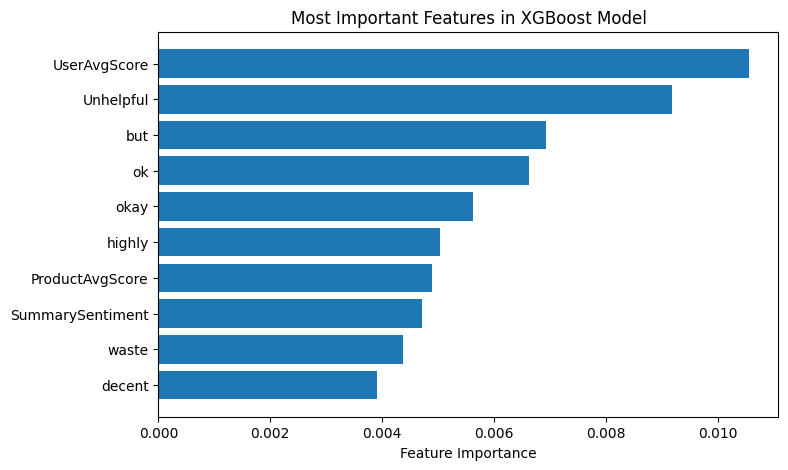

In [286]:
sorted_idx = model.feature_importances_.argsort()[-10:][::-1]
top_features = np.array(model.feature_importances_)[sorted_idx]

plt.figure(figsize=(8, 5))
plt.barh(range(10), top_features, align='center')
plt.yticks(range(10), np.array(model.feature_names_in_)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Most Important Features in XGBoost Model")
plt.gca().invert_yaxis() 
plt.show()

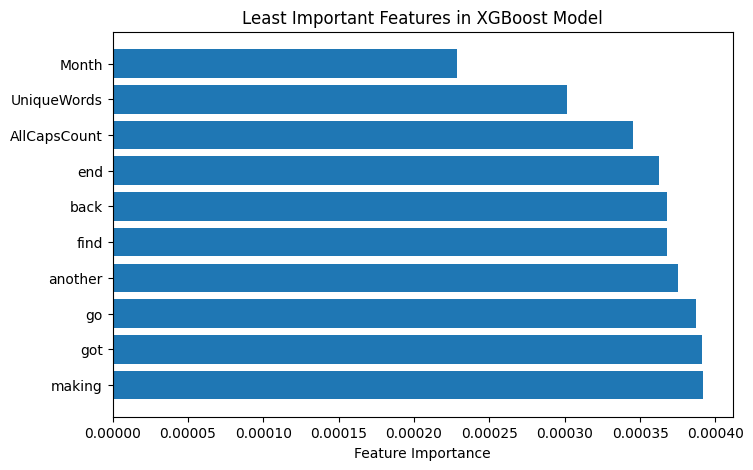

In [285]:
sorted_idx = model.feature_importances_.argsort()[1:11]
top_features = np.array(model.feature_importances_)[sorted_idx]

plt.figure(figsize=(8, 5))
plt.barh(range(10), top_features, align='center')
plt.yticks(range(10), np.array(model.feature_names_in_)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Least Important Features in XGBoost Model")
plt.gca().invert_yaxis() 
plt.show()

In [113]:
indexes = model.feature_importances_.argsort()[:100]
least_important_column_names = X_train_full.columns[indexes]
least_important_column_names

Index(['Month', 'UniqueWords', 'AllCapsCount', 'end', 'back', 'another',
       'find', 'deleted', 'part', 'things', 'got', 'place', 'real',
       'difference', 'stage', 'comes', 'long', 'something', 'go', 'taking',
       'scene', 'watch', 'director', 'secret', 'cast', 'making', 'begin',
       'together', 'screen', 'come', 'guy', 'played', 'bruce', 'sure',
       'without', 'sense', 'high', 'gets', 'home', 'use', 'sets', 'white',
       'john', 'put', 'look', 'view', 'getting', 'watching', 'want', 'child',
       'matter', 'man', 'feel', 'bring', 'girl', 'need', 'told', 'self',
       'west', 'tell', 'visual', 'far', 'came', 'store', 'ahead', 'fan',
       'crew', 'etc', 'earth', 'last', 'brothers', 'exciting', 'thinks',
       'king', 'rich', 'night', 'turns', 'looking', 'wife', 'directors',
       'wants', 'went', 'goes', 'say', 'becoming', 'house', 'later', 'appears',
       'turn', 'talk', 'involved', 'recently', 'whole', 'woman', 'black',
       'point', 'work', 'price', 'ago',

### Evaluate

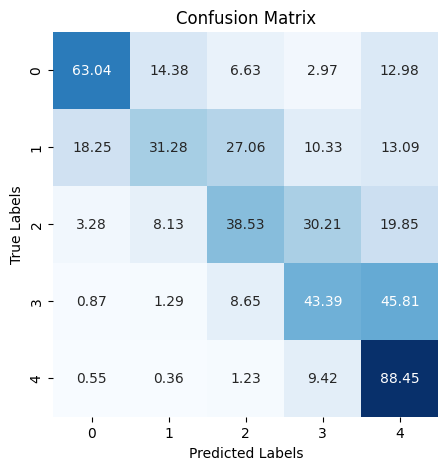

Accuracy: 67.35%
prediction set: Counter({np.int32(5): 182723, np.int32(4): 57061, np.int32(3): 27377, np.int32(1): 17377, np.int32(2): 12529})


In [265]:
y_pred = model.predict(X_test_full)
y_pred = y_pred+1
evaluate(y_pred)

In [270]:
submission.drop(columns=['Id'], axis=1,inplace=True)

In [271]:
submission_pred = model.predict(submission)
submission_pred = submission_pred + 1

In [276]:
assert len(submission_pred) == 212192

In [273]:
get_submission_ready(submission_pred)

Saved as submission.csv success!


In [275]:
import pickle
with open("models/xgb_final.pkl", 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to models/xgb_final.pkl")

Model saved to models/xgb_final.pkl
